In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Visualization
import matplotlib.cm as cm
from sklearn import random_projection
from sklearn.utils import check_arrays

import datetime

ImportError: cannot import name 'check_arrays' from 'sklearn.utils' (C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\sklearn\utils\__init__.py)

In [4]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32',
    'Week': 'int32',
    'Year':'int32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
processed_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'
timeseries_path = r'D:\NOVAIMS_MAA\timeseries\product_total_ts.csv'

In [5]:
example = pd.read_csv(processed_path,dtype=dtype_dict,parse_dates=['Date'],nrows = 100,usecols = [1,2,3,4,5,6,7,8,9])
example.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0


In [6]:
df = pd.read_csv(timeseries_path,dtype=dtype_dict,usecols = [1,2,3,4,5])

In [7]:
df.head()

,Year,Month,Week,ProductName_ID,Quantity
0,2016,1,1,1000,766.0
1,2016,1,1,1004,727.0
2,2016,1,1,1006,491.0
3,2016,1,1,1007,636.0
4,2016,1,1,1013,1641.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7174080 entries, 0 to 7174079
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Year            int32   
 1   Month           int64   
 2   Week            int32   
 3   ProductName_ID  category
 4   Quantity        float32 
dtypes: category(1), float32(1), int32(2), int64(1)
memory usage: 150.6 MB


In [192]:
def preprocessing(dataframe,product_id, period = "Month"):
    if period == "Month":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Month']).sum()['Quantity'].reset_index()
        data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data['TimeSeries'] = data['Year'].astype('string') + data['Month']
        #drop non-relevant columns
        data.drop(['Year','Month'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.sort_index(inplace=True)
        print("monthly timeseries generated")
        return data
    elif period == "Week":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Week']).sum()['Quantity'].reset_index()      
        data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data = data[data['Week'] != "53"]
        data['TimeSeries'] = data['Year'].astype('string') + data['Week']
        #drop non-relevant columns
        data.drop(['Year','Week'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.dropna(inplace=True)
        data.sort_index(inplace=True)
        print("weekly timeseries generated")
        return data
    else:
        print("Error, chosen period not available")   

def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    dataset_val = dataset.values
    for i in range(interval, len(dataset)):
        value = dataset_val[i] - dataset_val[i - interval]
        diff.append(value[0])
    return pd.DataFrame({'diff':diff},index = dataset[1:].index)

def scale_func(df,size_split):
    len_df = df.shape[0]
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:int(len_df*size_split),:])
    scaled_data = scaler.transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler
def reshape_input(X,Y):
    X, Y = np.array(X), np.array(Y)
    Y = Y.reshape(Y.shape[0], Y.shape[1])
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,Y
#create the training data set
def generate_input(df, window, out,size_split = 0.8):
    # df is the differencing dataframe
    #create the scaled training data set
    scaled_data, scaler = scale_func(df,size_split=size_split)
    #Split the data into x_train and y_train data sets
    len_df = scaled_data.shape[0]
    x_train,y_train = [],[]
    x_val,y_val = [],[]
    train_size = int(len_df*size_split)
    for i in range(window, train_size-out+1):
        x_train.append(scaled_data.iloc[i-window:i,:])
        y_train.append(scaled_data.iloc[i:(i+out),:])
    x_train,y_train = reshape_input(x_train,y_train)
    for i in range(train_size, len_df-out+1):
        x_val.append(scaled_data.iloc[i-window:i,:])
        y_val.append(scaled_data.iloc[i:(i+out),:])
    x_val,y_val = reshape_input(x_val,y_val)
    #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))
    return x_train, y_train, x_val,y_val, scaled_data,scaler

def model_base_build(input_shape,output_len):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=False,  input_shape = input_shape))
    #model.add(LSTM(10, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(output_len))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
# inverse data transform on forecasts
def inverse_transform(data, forecasts, scaler, x_val):
    inverted = list()
    out_put_len = forecasts.shape[1]
    for i in range(len(forecasts)): 
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(data) - len(x_val) + i - out_put_len
        last_ob = data.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def plot_series(data,figsize=(18,8)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)      

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, out):
    plt.figure(figsize=(16,8))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(data.loc[val_df.index], label = "Validation")
    if out == 1:
        lines = pd.Series()
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            lines = lines.append(pd.Series(yaxis[0],index = xaxis))
        plt.plot(lines.index, lines.values, color='red')
    # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
        return lines
	# plot the forecasts in red
    else:
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            plt.plot(xaxis, yaxis, color='red')
        # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()

In [71]:
# Check for top 10 products
df.groupby('ProductName_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductName_ID
1277    3170543.0
2609    3070767.0
481     2983412.0
993     2837871.0
1147    2801077.0
1234    2528432.0
2802    2521720.0
847     2447311.0
226     2437948.0
1422    2414555.0
Name: Quantity, dtype: float32

In [178]:
data = preprocessing(df,product_id='481')

monthly timeseries generated


In [179]:
data.head()

,Quantity
TimeSeries,
201601,141003.0
201602,109000.0
201603,102745.0
201604,68326.0
201605,57790.0


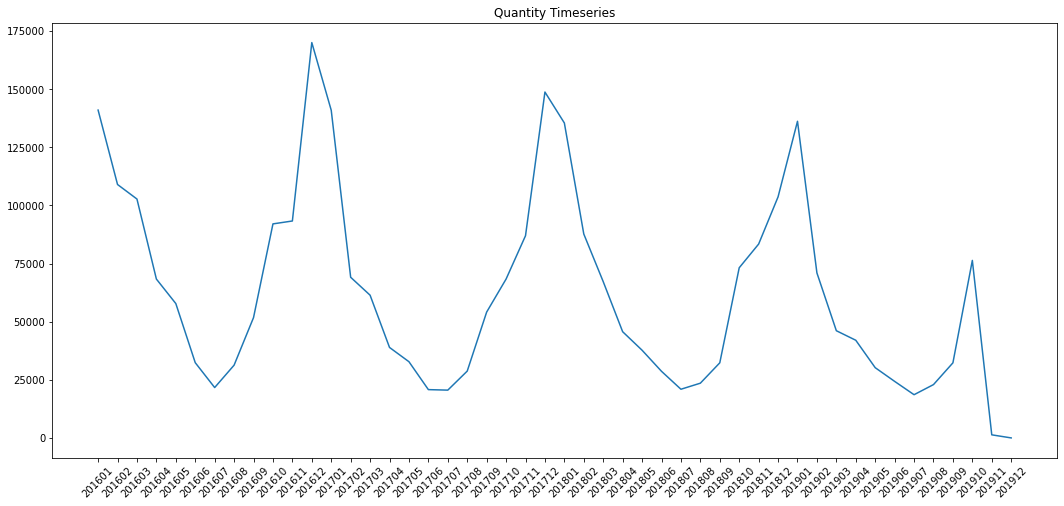

In [180]:
plot_series(data)

In [94]:
data.drop(index = ["201911","201912"],inplace = True)

In [95]:
n = data.shape[0]
train_df = data[0:int(n*.8)]
val_df = data[int(n*0.8):]

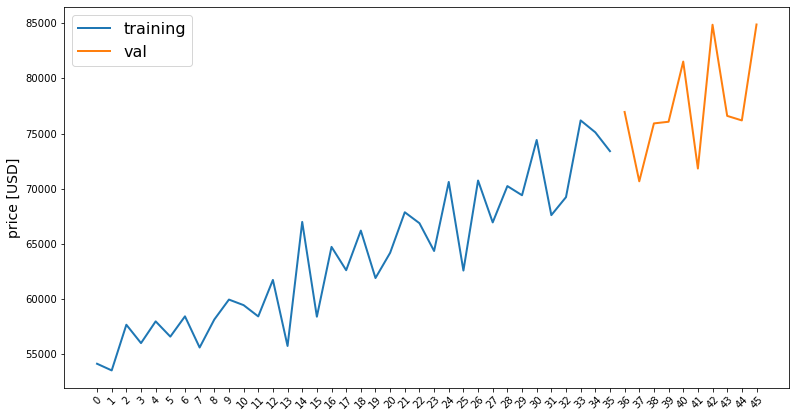

In [96]:
line_plot2(line1 = train_df, 
          line2 = val_df, label1='training',label2='val',title='')

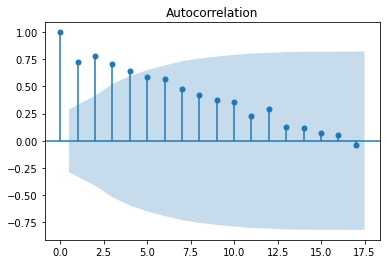

In [105]:
plot_acf(data)
plt.show()

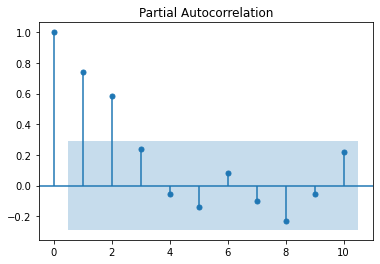

In [104]:
plot_pacf(data, lags=10)
plt.show()

In [106]:
dataset = difference(data)

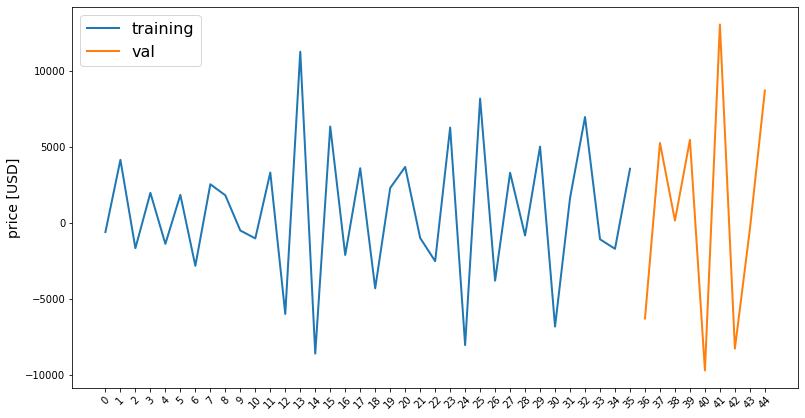

In [111]:
n = dataset.shape[0]
train_df = dataset[0:int(n*.8)]
val_df = dataset[int(n*0.8):]
line_plot2(line1 = train_df, line2 = val_df, label1='training',label2='val',title='')

In [126]:
x_train, y_train, x_val, y_val, scaled_df, scaler = generate_input(dataset,window = 6, out = 3)

In [127]:
print(scaled_df.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(45, 1)
(28, 6, 1)
(28, 3)
(7, 6, 1)
(7, 3)


In [131]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]),output_len=y_train.shape[1])

history1 = LSTM1.fit(x_train, y_train, batch_size=1, epochs=180   ,validation_data=(x_val,y_val))

===========] - 0s 3ms/step - loss: 4.0531e-04 - val_loss: 0.0825
Epoch 812/1000
28/28 [==============================] - 0s 4ms/step - loss: 2.2764e-04 - val_loss: 0.0849
Epoch 813/1000
28/28 [==============================] - 0s 3ms/step - loss: 6.2606e-04 - val_loss: 0.0856
Epoch 814/1000
28/28 [==============================] - 0s 3ms/step - loss: 6.7208e-04 - val_loss: 0.0896
Epoch 815/1000
28/28 [==============================] - 0s 3ms/step - loss: 8.8036e-04 - val_loss: 0.0806
Epoch 816/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0824
Epoch 817/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0890
Epoch 818/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0838
Epoch 819/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0844
Epoch 820/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0790
E

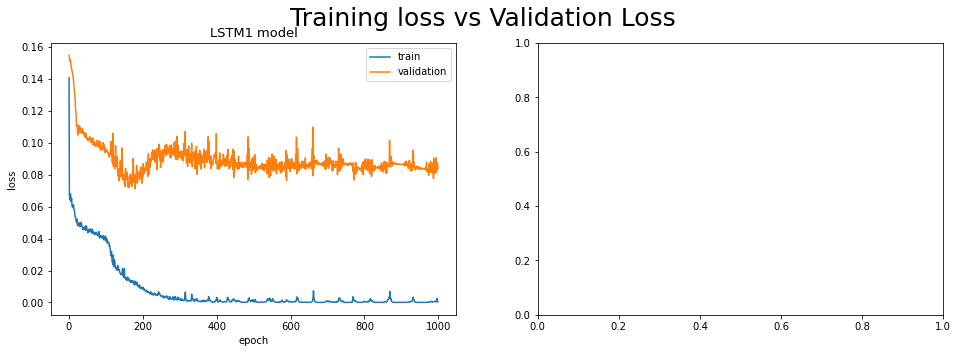

In [132]:
histories = [history1]
names = ['LSTM1']
plot_loss_histories(histories,names)

In [145]:
forecasts = LSTM1.predict(x_val)
evaluate_forecasts(y_val, forecasts, 6, 3)

t+1 RMSE: 0.211849
t+2 RMSE: 0.246267
t+3 RMSE: 0.381414


In [192]:
y_val_original = inverse_transform(data,y_val,scaler,x_val)
y_predicted = inverse_transform(data,forecasts,scaler,x_val)
evaluate_forecasts(y_val_original, y_predicted, 6, 3)

t+1 RMSE: 4198.422085
t+2 RMSE: 4830.863484
t+3 RMSE: 3675.041088


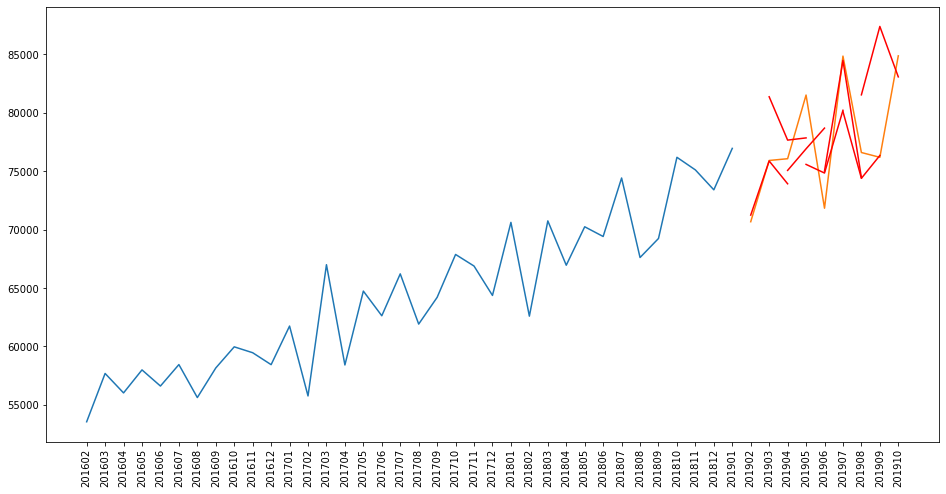

In [190]:
plot_forecasts(data,train_df,val_df,y_predicted,3)

# Weekly forecast

In [60]:
# Check for top 10 products
df.groupby('ProductName_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductName_ID
1277    3170543.0
2609    3070767.0
481     2983412.0
993     2837871.0
1147    2801077.0
1234    2528432.0
2802    2521720.0
847     2447311.0
226     2437948.0
1422    2414555.0
Name: Quantity, dtype: float32

In [92]:
data = preprocessing(df,product_id='2609',period="Week")

weekly timeseries generated


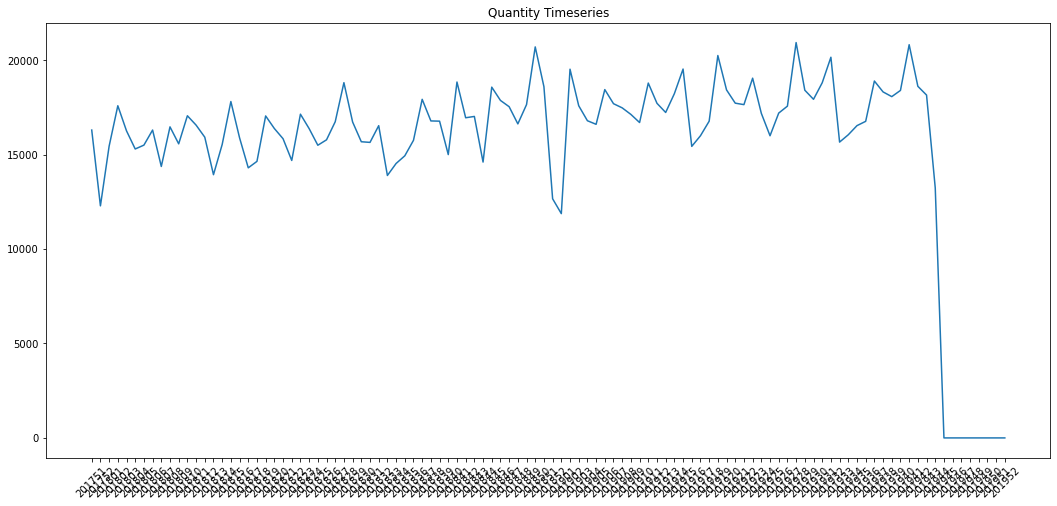

In [94]:
plot_series(data.iloc[-106:])

In [95]:
invalid_index = data.loc['201945':].index
data.drop(index = invalid_index,inplace = True)

In [96]:
n = data.shape[0]
train_df = data[0:int(n*.8)]
val_df = data[int(n*0.8):]

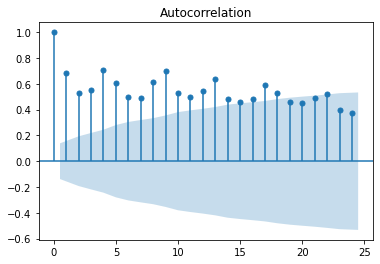

In [97]:
plot_acf(data)
plt.show()

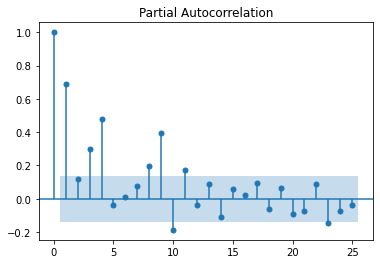

In [98]:
plot_pacf(data, lags=25)
plt.show()

In [99]:
data

,Quantity
TimeSeries,
201601,13109.0
201602,13875.0
201603,13002.0
201604,12562.0
201605,12825.0
...,...
201940,18399.0
201941,20819.0
201942,18616.0


In [100]:
dataset = difference(data)

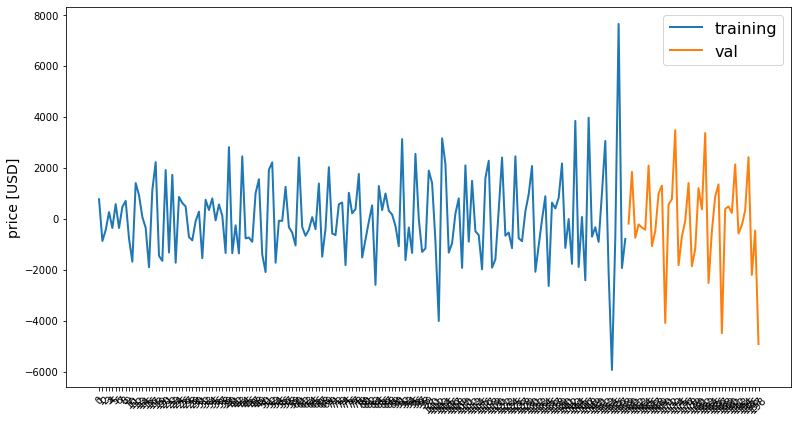

In [101]:
n = dataset.shape[0]
train_df = dataset[0:int(n*.8)]
val_df = dataset[int(n*0.8):]
line_plot2(line1 = train_df, line2 = val_df, label1='training',label2='val',title='')

In [72]:
x_train, y_train, x_val, y_val, scaled_df, scaler = generate_input(dataset,window = 6, out = 3)

In [102]:
print(scaled_df.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(202, 1)
(153, 6, 1)
(153, 3)
(39, 6, 1)
(39, 3)


In [105]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]),output_len=y_train.shape[1])
history1 = LSTM1.fit(x_train, y_train, batch_size=4, epochs=100   ,validation_data=(x_val,y_val))

Epoch 1/100
39/39 [==============================] - 5s 24ms/step - loss: 0.1146 - val_loss: 0.0077
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0062
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0049
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0048
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 8/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 9/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0052
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0047
Epoch 11

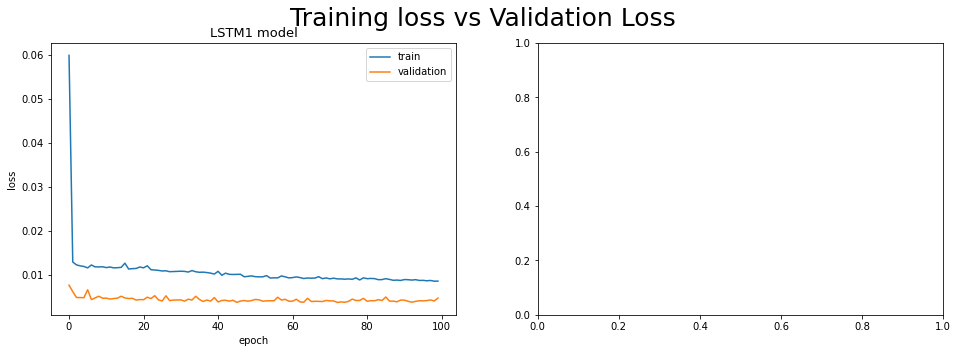

In [107]:
histories = [history1]
names = ['LSTM1']
plot_loss_histories(histories,names)

In [108]:
forecasts = LSTM1.predict(x_val)
evaluate_forecasts(y_val, forecasts, 6, 3)

t+1 RMSE: 0.074053
t+2 RMSE: 0.060808
t+3 RMSE: 0.070936


In [109]:
y_val_original = inverse_transform(data, y_val, scaler,x_val)
y_predicted = inverse_transform(data,forecasts,scaler,x_val)
evaluate_forecasts(y_val_original, y_predicted, 6, 3)

t+1 RMSE: 2081.322296
t+2 RMSE: 2407.387900
t+3 RMSE: 2694.478150


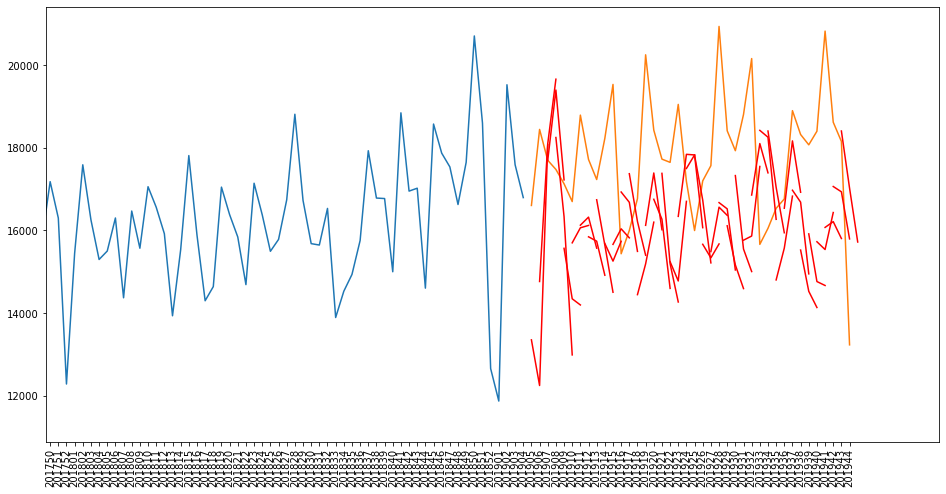

In [123]:
plot_forecasts(data,train_df,val_df,y_predicted,3)

## 1 week ahead

Epoch 1/100
78/78 [==============================] - 5s 14ms/step - loss: 0.0387 - val_loss: 0.0200
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0221
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0204
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0193
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0186
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0170 - val_loss: 0.0227
Epoch 8/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0176
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0223
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0201 - val_loss: 0.0169
Epoch 11

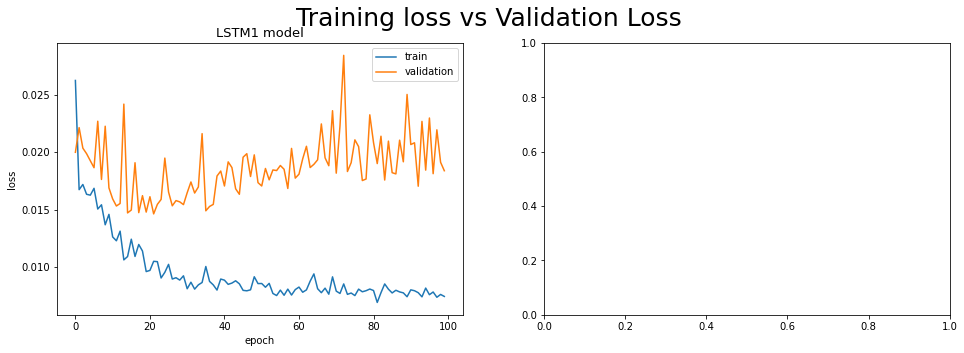

In [124]:
x_train, y_train, x_val, y_val, scaled_df, scaler = generate_input(dataset,window = 4, out = 1)
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]),output_len=y_train.shape[1])
history1 = LSTM1.fit(x_train, y_train, batch_size=2, epochs=100   ,validation_data=(x_val,y_val))
histories = [history1]
names = ['LSTM1']
plot_loss_histories(histories,names)

In [125]:
forecasts = LSTM1.predict(x_val)
evaluate_forecasts(y_val, forecasts, 4, 1)

t+1 RMSE: 0.135585


In [191]:
y_val_original = inverse_transform(data, y_val, scaler,x_val)
y_predicted = inverse_transform(data,forecasts,scaler,x_val)
evaluate_forecasts(y_val_original, y_predicted, 4, 1)

t+1 RMSE: 1841.376659
t+1 MAPE: 0.07


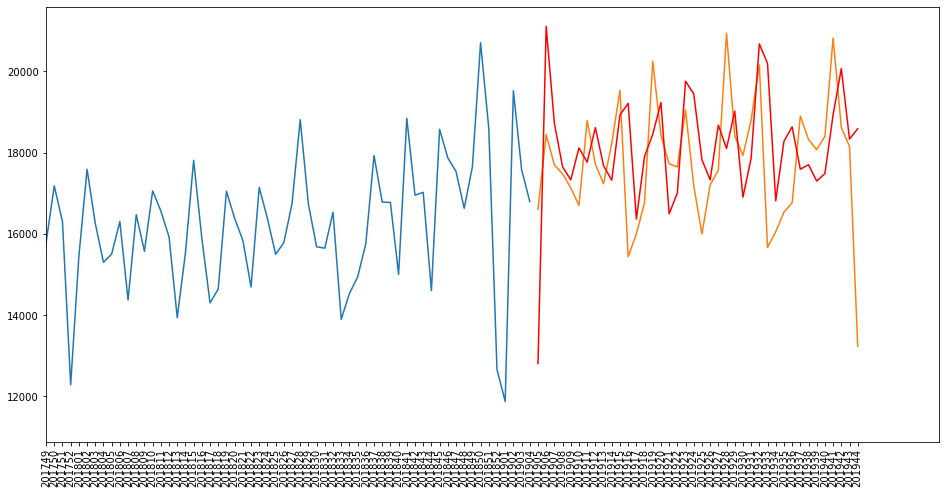

In [155]:
lines = plot_forecasts(data,train_df,val_df,y_predicted,1)